# Modèle de Heston

Le modèle de Heston est un modèle stochastique à volatilité non constante utilisé pour la modélisation de l'évolution du prix d’un actif. Pour chaque actif i, il est défini par le système d'équations différentielles stochastiques suivant :

\[
\begin{cases}
dS_t^{(i)} = \mu S_t^{(i)}\, dt + \sqrt{v_t^{(i)}}\, S_t^{(i)}\, dB_t^{(i)}   -->  dln(S_t^{(i)}) = (\mu - 0.5.v_t^{(i)})dt + \sqrt{v_t^{(i)}}\, dB_t^{(i)}\\
dv_t^{(i)} = \kappa^{(i)}(\theta^{(i)} - v_t^{(i)})\, dt + \sigma^{(i)} \sqrt{v_t^{(i)}}\, dW_t^{(i)} \\
\end{cases}
\]

avec une corrélation entre les deux mouvements browniens donnée par :

\[
\begin{cases}
dB_t^{(i)} dW_t^{(i)} = \rho^{(i)}\, dt \\
\end{cases}
\]

### Signification des paramètres :

- \( S_t \) : prix de l’actif à l’instant \( t \)
- \( v_t \) : variance instantanée (volatilité au carré)
- \( \mu \) : taux de rendement de l’actif
- \( \kappa \) : vitesse de retour à la moyenne
- \( \theta \) : niveau de variance de long terme
- \( \sigma \) : volatilité de la variance (aussi appelée "vol of vol")
- \( \rho \) : corrélation entre les deux bruits browniens


### Importation Librairies + Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp

from scipy.optimize import minimize
from utils import generate_evolution

In [2]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
Data10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]
# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    Data10y_dic[company] = df

# Create a DataFrame with all the closing prices
dfs = [df['clot'] for df in Data10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

data = histo_CAC40.dropna()
data.head(5)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-06-05,45.22,98.98,81.382,28.680,21.730,53.12,39.52,20.858,114.80,14.326,...,73.80,33.963,11.028,21.16,136.5,108.70,48.840,192.45,18.686,82.435
2018-06-06,45.04,100.00,82.206,29.485,21.630,53.69,39.82,20.956,114.70,14.103,...,73.94,33.885,11.186,21.46,136.4,108.40,49.233,192.20,18.512,82.474
2018-06-07,44.00,99.65,82.056,28.750,21.800,54.11,39.62,20.868,113.45,14.075,...,74.20,34.127,11.279,21.24,136.7,108.05,49.849,193.70,18.531,82.144
2018-06-08,43.40,100.90,82.056,28.045,21.800,53.70,39.18,21.112,113.20,13.908,...,73.60,33.908,11.219,21.04,137.3,110.35,49.587,192.10,18.406,81.853
2018-06-11,43.75,100.90,83.031,28.600,21.985,54.68,39.36,21.122,113.60,13.968,...,74.24,34.445,11.159,21.35,137.4,109.60,49.871,189.60,18.478,81.989


### Calcul des log-returns daily, realized_var

In [3]:
window = 20

# Compute the log returns daily
log_return_daily = np.log(data / data.shift(1)) / (data.index.to_series().diff().dt.total_seconds().values.reshape(-1, 1)) *3600*24
log_return_daily.dropna(inplace=True)

#Compute the rolling variance using a window of window days for each stock
realized_var = log_return_daily.rolling(window).var()
realized_var.dropna(inplace=True)
log_return_daily = log_return_daily.loc[realized_var.index]

#### Estimation de mu. Puis kappa, theta et sigma
Rappel :

\[
\begin{cases}
dln(S_t^{(i)}) = (\mu - 0.5.v_t^{(i)})dt + \sqrt{v_t^{(i)}}\, dB_t^{(i)}\\
[dv_t^{(i)} - \kappa^{(i)}(\theta^{(i)} - v_t^{(i)})\, dt] / \sigma^{(i)}/ \sqrt{v_t^{(i)}}\, = dW_t^{(i)} \\
\end{cases}
\]

Donc mu est la moyenne des log-returns

In [4]:
def calibrate_heston_model(data : pd.DataFrame, window : int = 20,  params_init : list = [3., 0.15], bounds : list = [(1e-3, 40.), (1e-3, 1.)]):
    log_return_day = np.log(data / data.shift(1)) / (data.index.to_series().diff().dt.total_seconds().values.reshape(-1, 1)) *3600*24
    log_return_day.dropna(inplace=True)
    realized_var = log_return_day.rolling(window).var()
    realized_var.dropna(inplace=True)
    log_return_day = log_return_day.loc[realized_var.index]
    mu = log_return_day.mean(axis=0) * 365.25
    realized_var_annualized = realized_var * 365.25
    d_realized_var_annualized = realized_var_annualized.diff().dropna()
    df_params = pd.DataFrame(columns=d_realized_var_annualized.columns, index=['V_end', 'S_end', 'mu', 'kappa', 'theta', 'sigma'])
    df_params.index.name = 'parameters'
    df_params.columns.name = 'companies'
    df_params.loc['mu'] = mu
    df_params.loc['V_end'] = realized_var_annualized.iloc[-1].values
    df_params.loc['S_end'] = data.iloc[-1].values

    def heston_log_likelihood(params : list, variance : np.ndarray) -> float:
        kappa, theta = params
        dt = 1/365.25  # pas de temps (1 jour)
        d_variance = variance[1:] - variance[:-1]
        sigma = d_variance.std()*(365.25**0.5)
        # - log_likelihood
        objective_value = (d_variance - kappa * (theta - variance[:-1])*dt)**2 / sigma**2 / variance[:-1] / dt
        return np.sum(objective_value)

    for column in df_params.columns:
        var_col = realized_var_annualized[column].values
        # Optimize the parameters using a minimization algorithm
        resultat = minimize(heston_log_likelihood, params_init, args=(var_col,), bounds=bounds, method='L-BFGS-B')
        df_params.loc['kappa', column] = resultat.x[0]
        df_params.loc['theta', column] = resultat.x[1]
        d_var_col = var_col[1:] - var_col[:-1]
        sigma = d_var_col.std()*(365.25**0.5)
        df_params.loc['sigma', column] = sigma
        if resultat.x[0] < 0.01 or resultat.x[1] < 0.01:
            print(f"Warning for {column} with params {resultat.x}. The result value is {resultat.fun}. and the sigma is {sigma}.")
            continue
    
    dB = (log_return_daily-(mu - realized_var_annualized/2)/365.25) / realized_var_annualized**0.5 * (365.25**0.5)
    dB.columns = [f'{col}_dB' for col in dB.columns]
    variance = realized_var_annualized.values
    d_variance = variance[1:] - variance[:-1]
    dW = (d_realized_var_annualized - df_params.loc['kappa'].values * (df_params.loc['theta'].values * np.ones(d_realized_var_annualized.shape) - variance[:-1]) * (1/365.25)) / df_params.loc['sigma'].values / variance[:-1]**0.5 / (1/365.25)**0.5
    dW.columns = [f'{col}_dW' for col in dW.columns]
    dB_dW = pd.concat([dB, dW], axis=1)
    dB_dW.dropna(inplace=True)

    return df_params, dB_dW.corr()

In [5]:
df_params, dBdW = calibrate_heston_model(data, window=10)

In [6]:
df_params

companies,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
parameters,,,,,,,,,,,,,,,,,,,,,
V_end,0.114648,0.124594,0.02807,0.90939,0.034692,0.151756,0.177425,0.080949,0.320673,0.036314,...,0.246402,0.185717,0.678923,0.582463,0.811224,0.36297,0.038721,0.092059,0.022744,0.104308
S_end,46.59,169.56,180.3,30.48,38.76,76.57,35.59,29.24,153.75,13.03,...,223.9,42.075,11.638,23.725,102.6,236.7,56.54,75.2,30.77,117.0
mu,0.065539,0.111964,0.167081,-0.009804,0.114388,0.083112,0.015773,0.083721,0.141494,-0.046451,...,0.26373,0.095469,0.038378,0.080162,-0.023927,0.0509,-0.016927,-0.160938,0.13198,0.102826
kappa,10.915216,8.648634,16.298024,16.27492,12.567868,14.698156,11.588287,13.136454,14.186332,27.778975,...,16.736613,13.404856,17.478204,23.491764,16.101035,15.988189,12.901921,7.130532,11.836057,8.56676
theta,0.128306,0.171398,0.048904,0.227367,0.074678,0.12075,0.092697,0.065294,0.116161,0.08684,...,0.097676,0.170543,0.167756,0.201675,0.21174,0.093596,0.091671,0.239618,0.087624,0.089514
sigma,1.270224,2.054089,0.482863,1.807978,1.151267,0.922251,1.281215,0.554837,0.906,0.923387,...,0.841169,1.595501,1.601992,1.602125,4.771331,0.784292,1.186981,2.623266,0.923773,1.198376


In [7]:
def generate_HestonM_scenarios(df_params : pd.DataFrame, dBdW : pd.DataFrame, beginDate : str, endDate : str, number_of_scenarios : int = 1000, V_init : float = None) -> dict:
    """
    Generate Heston-Monte Carlo scenarios.
    """
    # Get the parameters
    mu = df_params.loc['mu']
    kappa = df_params.loc['kappa']
    theta = df_params.loc['theta']
    sigma = df_params.loc['sigma']
    nb_stocks = len(mu)
    if V_init is None:
        V_init = df_params.loc['V_end']
    # generate dates excluding Saturdays and Sundays
    dates = pd.date_range(start=beginDate, end=endDate, freq='B')
    nb_periods = len(dates)
    # Calculate the adjustment factor for volatilities
    delta_t = dates.to_series().diff().dt.days[1:] / 365.25
    delta_t = np.insert(delta_t, 0, 0)
    # Generate scenarios of dB and dW ==> 2*nb_stocks brownian motions per scenarios
    choelesky_matrix = np.linalg.cholesky(dBdW.values)
    lReturns_Variance = np.random.normal(0, 1, (nb_periods, nb_stocks*2, number_of_scenarios))
    for i in range(number_of_scenarios):
        lReturns_Variance[:, :, i] = np.dot(lReturns_Variance[:, :, i], choelesky_matrix)
    
    # Variance paths
    variance_paths = {}
    for i in range(number_of_scenarios):
        variance_path = np.zeros((nb_periods, nb_stocks))
        variance_path[0, :] = V_init.values
        for j in range(1, nb_periods):
            variance_path[j, :] = np.maximum(variance_path[j-1, :] + kappa.values * (theta.values - variance_path[j-1, :]) * delta_t[j] + sigma.values * np.sqrt(variance_path[j-1, :]) * lReturns_Variance[j, nb_stocks:, i]* delta_t[j]**0.5, 0) 
        variance_paths[f"Scenario {i+1}"] = pd.DataFrame(variance_path, index=dates, columns=df_params.columns)
    
    # Log return paths
    log_return_paths = {}
    for i in range(number_of_scenarios):
        log_return_path = np.zeros((nb_periods, nb_stocks))
        log_return_path[0, :] = 0.0
        for j in range(1, nb_periods):
            log_return_path[j, :] = (mu.values - variance_paths[f"Scenario {i+1}"].iloc[j-1, :] / 2) * delta_t[j] + np.sqrt(variance_paths[f"Scenario {i+1}"].iloc[j-1, :]) * lReturns_Variance[j, :nb_stocks, i] * delta_t[j]**0.5
        log_return_paths[f"Scenario {i+1}"] = pd.DataFrame(log_return_path, index=dates, columns=df_params.columns)

    
    return log_return_paths, variance_paths

In [16]:
# gernerate scenarios
log_return_paths, variance_paths = generate_HestonM_scenarios(df_params, dBdW, '2023-01-01', '2028-01-01', number_of_scenarios=10, V_init=None)
log_return_paths['Scenario 5']

companies,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
2023-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-03,-0.007005,0.026121,0.012751,0.019205,0.022108,0.032893,0.022995,-0.005219,-0.020421,-0.002498,...,0.003997,-0.000640,-0.021410,-0.017769,-0.038697,0.047399,0.000635,-0.006742,-0.002412,0.016952
2023-01-04,-0.068621,-0.068289,-0.038556,-0.064711,-0.003325,0.019898,-0.009871,-0.015067,-0.058520,-0.008620,...,0.010111,0.001065,-0.006813,-0.026797,-0.070799,0.006518,0.008831,0.009835,-0.001312,0.006990
2023-01-05,-0.021545,-0.049212,-0.015439,-0.001156,0.008013,0.025890,0.028095,-0.027124,-0.028982,0.026789,...,0.003997,-0.013586,0.032846,-0.069043,-0.037003,-0.060706,-0.004680,0.009328,-0.002412,0.005402
2023-01-06,0.016093,-0.010613,0.000601,0.052611,0.018536,0.003600,-0.013698,-0.029927,-0.008764,0.008124,...,0.000149,0.009551,0.001445,-0.005470,0.058398,-0.009494,0.006225,-0.000878,-0.000287,0.002194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027-12-27,0.009835,0.007278,0.009437,0.007167,0.017094,0.017775,0.035756,-0.011275,0.010984,0.010935,...,0.013500,0.013727,0.025436,0.019655,-0.143571,-0.012099,-0.008692,-0.021993,0.033575,0.028414
2027-12-28,0.004485,0.004580,-0.018893,0.029881,0.001214,0.008695,0.004658,-0.016270,-0.020092,-0.021678,...,-0.013723,-0.001971,0.018253,0.004092,0.004826,0.007268,0.006276,-0.000557,-0.019887,-0.007887
2027-12-29,0.058102,0.024079,0.016320,0.024690,0.030630,0.017340,0.013215,-0.013128,0.007779,0.010593,...,0.003786,0.004852,0.012722,0.020125,0.019530,0.003256,0.002460,0.006921,-0.011273,-0.012699
2027-12-30,-0.039331,-0.029961,-0.020007,-0.086706,-0.010237,-0.017872,0.001441,-0.016033,-0.029860,0.012531,...,-0.004940,-0.002883,-0.018044,-0.016596,0.047082,0.013431,0.006429,0.021911,-0.008837,0.000345


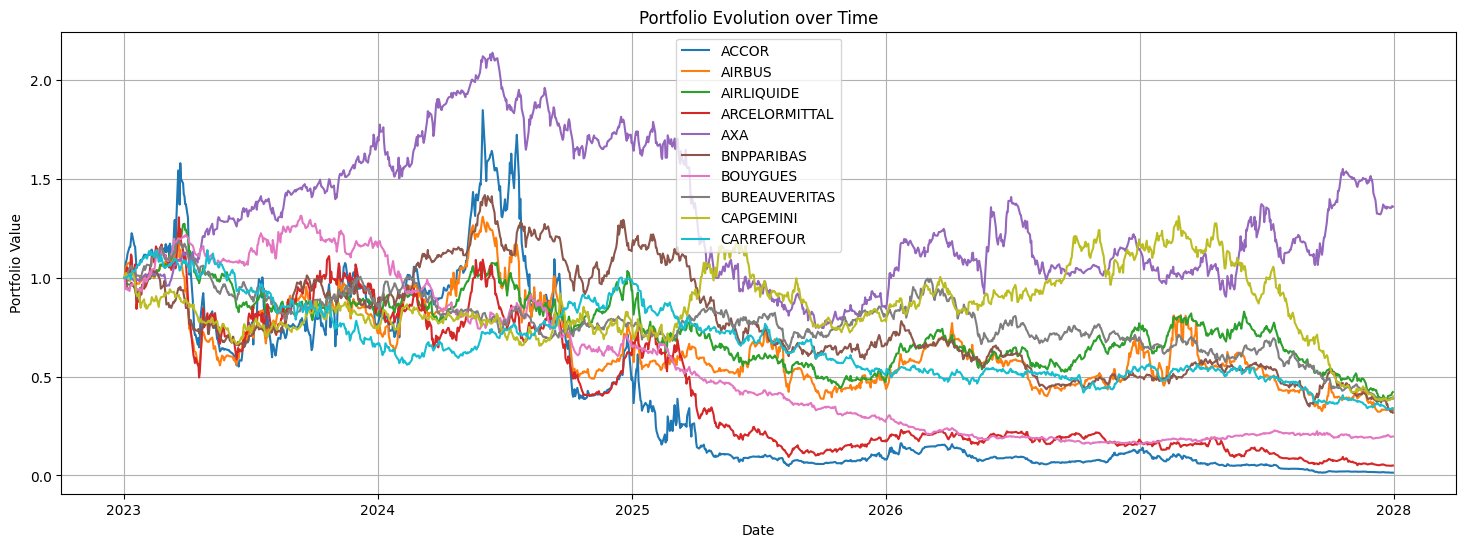

In [18]:
Evol = generate_evolution(log_return_paths['Scenario 2'], allocation=np.ones(40))

# Plot the evolution of the first companies portfolio (5)
plt.figure(figsize=(18, 6))
nb_stocks = 0
for i in range(10):
    plt.plot( Evol.iloc[:, nb_stocks], label=Evol.columns[nb_stocks])
    nb_stocks += 1

plt.title('Portfolio Evolution over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()

In [19]:
realized_var_annualized = realized_var * 365.25
d_realized_var_annualized = realized_var_annualized.diff().dropna()

In [20]:
dB = (log_return_daily-(df_params.loc['mu'] - realized_var_annualized/2)/365.25) / realized_var_annualized**0.5 * (365.25**0.5)
dB.columns = [f'{col}_dB' for col in dB.columns]
variance = realized_var_annualized.values

<Axes: >

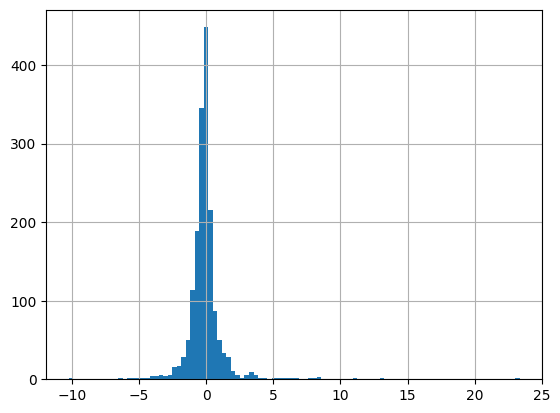

In [21]:
dW = (d_realized_var_annualized - df_params.loc['kappa'].values * (df_params.loc['theta'].values * np.ones(d_realized_var_annualized.shape) - variance[:-1]) * (1/365.25)) / df_params.loc['sigma'].values / variance[:-1]**0.5 / (1/365.25)**0.5
dW['LVMH'].hist(bins=100)